In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime as dt
from datetime import timedelta as td

%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 16]

In [2]:
# To know the memory usage, just in case out of memory
import os, psutil

def memory_usage():
     process = psutil.Process(os.getpid())
     return process.memory_info()[0] / float(2 ** 20)

memory_usage() # initial memory usage

97.18359375

# The workflow: Indicator, Signal and strategy

## The column name protocols between different stages and staff
So that the data source can be interpreted by strategy

In [3]:
def ma_col_name(nperiods):
    return "MA"+str(nperiods)

def pre_ma_col_name(nperiods):
    return "Pre_"+ma_col_name(nperiods)

def crossup_col_name(ma_short, ma_long):
    return str(ma_short)+"_CU_"+str(ma_long)

def crossdown_col_name(ma_short, ma_long):
    return str(ma_short)+"_CD_"+str(ma_long)

## The MA parameters we will use

In [4]:
ma_range_short=list(range(5,10+1))
ma_range_long=list(range(25,35+1))
ma_range=ma_range_short+ma_range_long
ma_range

[5, 6, 7, 8, 9, 10, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

## The Stoploss level we will use

In [5]:
stoploss_range=[x/100.0 for x in range(1,5+1)]
stoploss_range=[0.005]+stoploss_range+[1]
stoploss_range

[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 1]

# Backtesting

# To Load Market Data Indicators and Signals
So that the step 1, 2 are independent to back testing

In [6]:
df=pd.read_csv("signals.csv" ,parse_dates=["datetime"],index_col="datetime")
df.sort_index(ascending=True,inplace=True)
# Test df.iloc[0]

## Backtesting

In [7]:
def strategy_test(df, ma_short=5, ma_long=25, stoploss_rate=0.05):
    """Backtest for a set of (MA short periods, MA long periods, stop loss rate)"""
    ticker_holdings = []  #Holding of ticks
    ticker_trades=[]
    ticker_stoploss=[]
    trades_pl=[]
    #stoplosses_pl=[]
    cash_flows=[]  #Cash flow (In when sell and out when buy)
    
    current_holding=0
    previous_cost_Buys=0
    previous_cost_Sells=0
    initial_cash=0  # The first investment as cash 
    crossdown=crossdown_col_name(ma_short,ma_long)
    crossup=crossup_col_name(ma_short,ma_long)
    
    for index, row in df.iterrows():  
        net_cash_flow=0
        trades=0 #non-cover
        stoploss_trades=0 #cover
        trade_pl=0
        #stoploss_pl=0
        
        if stoploss_rate<1: # When stoploss>=1, which means no stoploss!
            # stop loss first
            if current_holding>0 and row["close"]<((1-stoploss_rate)*previous_cost_Buys): # stop loss for long
                stoploss_trades=-current_holding
                current_holding=0
                net_cash_flow=(1-stoploss_rate)*previous_cost_Buys*abs(stoploss_trades)
                #stoploss_pl=-stoploss_rate # The loss
                trade_pl=-stoploss_rate # The loss
            elif current_holding<0 and row['close']>(1+stoploss_rate)*previous_cost_Sells: # stop loss for short
                stoploss_trades=-current_holding
                current_holding=0
                #stoploss_pl=-stoploss_rate
                trade_pl=-stoploss_rate # The loss
                net_cash_flow=-(1+stoploss_rate)*previous_cost_Sells*abs(stoploss_trades)
        
        bool_crossdown=row[crossdown]
        bool_crossup=row[crossup]
        
        # Then we deal with buy and sell signal
        if bool_crossup:
            if (current_holding<0): # cover short
                trade_pl=-(row["close"]/previous_cost_Sells-1)
            
            current_holding=current_holding+1
            net_cash_flow=net_cash_flow-row["close"]
            previous_cost_Buys=row["close"]
            trades=1
            
            
            if initial_cash==0:
                initial_cash=row["close"]
                
        elif bool_crossdown:
            if (current_holding>0): # cover long
                trade_pl=row["close"]/previous_cost_Buys-1
            
            current_holding=current_holding-1
            net_cash_flow=net_cash_flow+row["close"]
            previous_cost_Sells=row["close"]
            trades=-1
            
            if initial_cash==0:
                initial_cash=row["close"]
                  
        ticker_holdings.append(current_holding)
        cash_flows.append(net_cash_flow)
        ticker_trades.append(trades)
        ticker_stoploss.append(stoploss_trades)
        trades_pl.append(trade_pl)
        #stoplosses_pl.append(stoploss_pl)
        
    df_strategy=pd.DataFrame({"close":df["close"],"holding": ticker_holdings,"cash_flows":cash_flows, \
                          "trades":ticker_trades,"stoploss":ticker_stoploss, "trades_pl":trades_pl\
                              #,"stoplosses_pl":stoplosses_pl
                             },index=df.index)
                
    df_strategy["cum_cash_flow"]=df_strategy["cash_flows"].cumsum()
    df_strategy["cash"]=pd.Series([initial_cash+cum_cf for cum_cf in df_strategy["cum_cash_flow"]],index=df.index)
    df_strategy["strategy"]=df_strategy.holding*df_strategy.close+df_strategy["cash"]
    df_strategy["strategy_pl_cum"]=df_strategy["strategy"]/initial_cash-1
    
    return df_strategy

## We define the metrics 

In [8]:
# global parameters we share between 
annual_trading_days=252

risk_free=0.01 # for 2018 the low interest rate
risk_free_daily=(1+risk_free)**(1/annual_trading_days)-1 
annualized_parameter=annual_trading_days**0.5

target_daily_return=0 # We use 0 as the target daily return

### Sharpe Ratio

In [9]:
def sharpe_ratio(values):
    """To calculate Sharpe Ratio by portfolio values"""
    daily_return=values.pct_change()
    sharpe_ratio=(daily_return.mean()-risk_free_daily)/daily_return.std()
    sharpe_ratio_annual=annualized_parameter*sharpe_ratio
    return sharpe_ratio,sharpe_ratio_annual

### Sortino Ratio

In [10]:
def sortino_ratio(values,target_return=0):
    """To calculate Sortino Ratio by portfolio values"""    
    daily_return=values.pct_change()
    expected_return = daily_return.mean()

    df_temp=daily_return.to_frame("daily")
    sq_mean=df_temp.applymap(lambda x: (x-target_return)**2 if x<target_return else 0).mean()[0] 
    
    #print(sq_mean)
    down_stdev = np.sqrt(sq_mean)
    
    sortino_ratio = (expected_return - risk_free_daily)/down_stdev
    
    sortino_ratio_annual=annualized_parameter*sortino_ratio
    
    return sortino_ratio, sortino_ratio_annual

### Maximum Drawdown

In [11]:
def max_drawdown(values):
    """To calculate maximum drawdown"""
    max_dd=0
    for i in range(0,len(values)-1):
        min_value=values[i+1:].min()
        drawdown=min_value/values[i]-1
        
        if drawdown<max_dd:
            max_dd=drawdown
    
    if max_dd==0:
        return 0
    else:
        return abs(max_dd) # finally we use positive

In [12]:
def strategy_metrics(value_serie):
    """To calculate all required performance indicators"""
    sharpe,sharpe_annual=sharpe_ratio(value_serie)
    sortino, sortino_annual=sortino_ratio(value_serie)
    max_dd=max_drawdown(value_serie)
    return sharpe, sortino,max_dd

In [13]:
# clear global variables
df_metrics=pd.DataFrame()
series=[]
dfs={}

In [14]:
def all_strategy_test(ma_range_short,ma_range_long,stoploss_range):
    """Backtest parameter combinations of MA short range, MA long range and stop loss range."""
    global df_metrics,series,dfs
    df_metrics=pd.DataFrame()
    series=[]
    dfs={}
    
    for ma_short in ma_range_short:
        for ma_long in ma_range_long:
            for stoploss in stoploss_range:
                strategy_name=str(ma_short)+"_"+str(ma_long)+"_"+str(stoploss)
                df_strategy=strategy_test(df, ma_short, ma_long, stoploss)
                dfs[strategy_name]=df_strategy
                
                sharpe_ratio, sortino,max_dd=strategy_metrics(df_strategy.strategy)
            
                trades_total=(abs(df_strategy.trades)+abs(df_strategy.stoploss)).sum()
                trades_mean=df_strategy.trades_pl.mean()
                final_pl=df_strategy.strategy_pl_cum.iloc[-1]
                    
                series.append(pd.Series({"strategy_name":strategy_name,"ma_short":ma_short,"ma_long":ma_long,\
                                                        "stoploss": stoploss,"sharpe_ratio":sharpe_ratio,"sortino_ratio":sortino,\
                                                        "max_drawdown":max_dd,\
                                        "Final_Return":final_pl,"Total_Trades":trades_total,"Average_Trades_PL":trades_mean\
                                        }))               
    
    df_metrics=pd.concat(series,ignore_index=True,axis=1).T
    df_metrics.set_index('strategy_name', inplace=True)
    df_metrics.ma_short=df_metrics.ma_short.astype("int64")
    df_metrics.ma_long=df_metrics.ma_long.astype("int64")
    df_metrics.stoploss=df_metrics.stoploss.astype("float64")
    df_metrics.sharpe_ratio =df_metrics.sharpe_ratio.astype("float64")
    df_metrics.sortino_ratio =df_metrics.sortino_ratio.astype("float64")
    df_metrics.max_drawdown=df_metrics.max_drawdown.astype("float64")
    df_metrics.Final_Return=df_metrics.Final_Return.astype("float64")
    df_metrics.max_drawdown=df_metrics.max_drawdown.astype("float64")
    df_metrics.Total_Trades=df_metrics.Total_Trades.astype("int64")
    df_metrics.Average_Trades_PL=df_metrics.Average_Trades_PL.astype("float64")

## To Back Test All Strategy Combinations (about 25 minutes)

In [15]:
dt_start=dt.datetime.now()
all_strategy_test(ma_range_short,ma_range_long,stoploss_range) 
#all_strategy_test([7],[35],stoploss_range) 
dt_end=dt.datetime.now()
print(dt_end-dt_start)
df_metrics.head()

0:20:11.954249


,ma_short,ma_long,stoploss,sharpe_ratio,sortino_ratio,max_drawdown,Final_Return,Total_Trades,Average_Trades_PL
strategy_name,,,,,,,,,
5_25_0.005,5,25,0.005,0.005967,0.008879,0.091947,1.046471,1065,0.000088
5_25_0.01,5,25,0.010,-0.001482,-0.002158,0.160273,0.551697,905,0.000049
5_25_0.02,5,25,0.020,-0.003115,-0.004492,0.192186,0.444551,791,0.000044
5_25_0.03,5,25,0.030,-0.009929,-0.013981,0.279271,0.043530,776,0.000007
5_25_0.04,5,25,0.040,-0.006440,-0.009337,0.236733,0.231064,769,0.000024


# Report Generation

In [16]:
# To chart the results
def chart_strategy_results(ma_range_short,ma_range_long,stoploss_range, indetail=False):
    global df_metrics,series,dfs
    
    nosubplot=len(ma_range_short)+len(ma_range_long)<=2
    
    if nosubplot:
        fig,axes=plt.subplots()
    else:
        fig,axes = plt.subplots(len(ma_range_short), len(ma_range_long), sharex='col', sharey='row')
    
    for ma_short in ma_range_short:
        for ma_long in ma_range_long:
            #print(ma_range_short.index(ma_short),ma_range_long.index(ma_long))
            
            if nosubplot:
                ax=axes
            else: 
                ax=axes[ma_range_short.index(ma_short),ma_range_long.index(ma_long)]
            
            ax.text(0.5, 0.5, str(ma_short)+"  "+str(ma_long), color='red', ha='center',transform=ax.transAxes)
                    #ax.set_title(str(ma_short)+"  "+str(ma_long))
            #ax.set_title("{:.2f}".format(sharpe_ratio)+",{:.2f}".format(sortino)+",{:.2f}".format(max_dd))
                    
            for stoploss in stoploss_range:
                # To fetch data
                strategy_name=str(ma_short)+"_"+str(ma_long)+"_"+str(stoploss)
                
                try:
                    df_strategy=dfs[strategy_name]
                
                    sharpe, sortino,max_dd,final_pl,trades_total,trades_mean\
                        =df_metrics.loc[strategy_name,["sharpe_ratio","sortino_ratio","max_drawdown",\
                                        "Final_Return","Total_Trades","Average_Trades_PL"]]
                except KeyError:
                    continue
                    
                # To chart
                #df_strategy.strategy_pl_cum.plot(ax=ax,label="{:.0%}".format(stoploss))
                if stoploss<1:
                    ax.plot(df_strategy.index, df_strategy.strategy_pl_cum, label="{:.1%}".format(stoploss))
                else:
                    ax.plot(df_strategy.index, df_strategy.strategy_pl_cum, label="No Stop Loss")
            
            if indetail:
                ax.legend(loc='lower left', shadow=True)

    plt.show()    


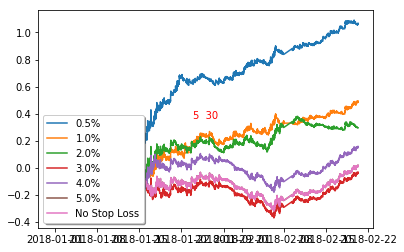

In [17]:
chart_strategy_results([5],[30],stoploss_range,True) # Test

In [18]:
df_metrics[(df_metrics.ma_short==5) & (df_metrics.ma_long==30)]

,ma_short,ma_long,stoploss,sharpe_ratio,sortino_ratio,max_drawdown,Final_Return,Total_Trades,Average_Trades_PL
strategy_name,,,,,,,,,
5_30_0.005,5,30,0.005,0.005900,0.008780,0.118090,1.061817,947,0.000097
5_30_0.01,5,30,0.010,-0.002114,-0.003050,0.221069,0.487084,815,0.000050
5_30_0.02,5,30,0.020,-0.005071,-0.007291,0.210301,0.295138,714,0.000035
5_30_0.03,5,30,0.030,-0.010061,-0.014475,0.432688,-0.038262,693,0.000005
5_30_0.04,5,30,0.040,-0.007273,-0.010518,0.261801,0.151366,689,0.000019
5_30_0.05,5,30,0.050,-0.009771,-0.014192,0.387121,0.012302,687,0.000009
5_30_1,5,30,1.000,-0.009771,-0.014192,0.387121,0.012302,687,0.000009


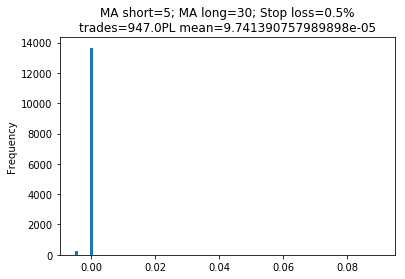

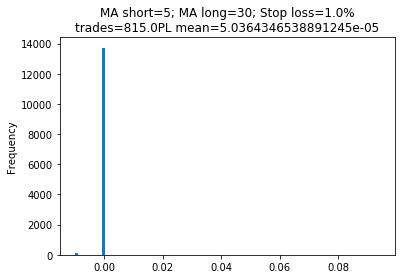

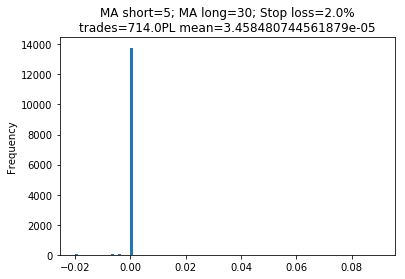

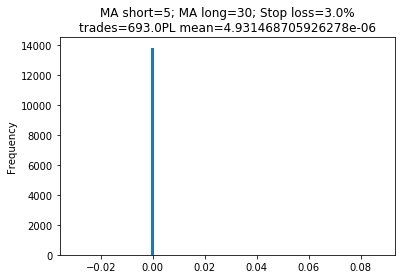

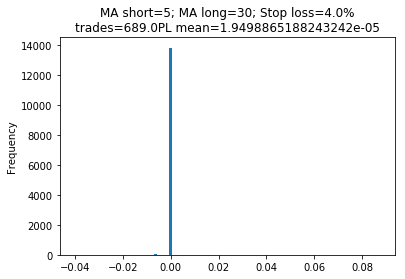

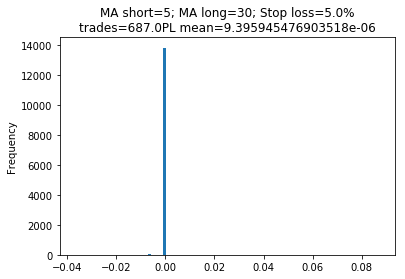

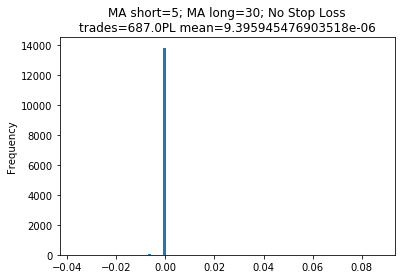

In [19]:
def chart_trade_pl(ma_short, ma_long, stoploss_range):
    for stoploss in stoploss_range:
        # To fetch data
        strategy_name=str(ma_short)+"_"+str(ma_long)+"_"+str(stoploss)
                
        try:
            df_strategy=dfs[strategy_name]
                
            sharpe, sortino,max_dd,final_pl,trades_total,trades_mean\
                        =df_metrics.loc[strategy_name,["sharpe_ratio","sortino_ratio","max_drawdown",\
                                        "Final_Return","Total_Trades","Average_Trades_PL"]]
        except KeyError:
            continue
                    
        df_strategy.trades_pl.plot(kind="hist",bins=100);
            
        if stoploss<1:
            plt.title("MA short="+str(ma_short)+"; MA long="+str(ma_long)+"; Stop loss={:.1%}".format(stoploss)+\
                          "\ntrades="+str(trades_total)+"PL mean="+str(trades_mean))
        else:
            plt.title("MA short="+str(ma_short)+"; MA long="+str(ma_long)+"; No Stop Loss"+\
                      "\ntrades="+str(trades_total)+"PL mean="+str(trades_mean))

        plt.show()

chart_trade_pl(5,30,stoploss_range)            

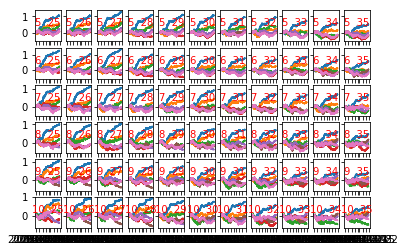

In [20]:
chart_strategy_results(ma_range_short,ma_range_long,stoploss_range) 

### To save the metrics data

In [21]:
df_metrics.to_csv("metrics.csv")

## Interactive Analysis on the metrics

In [22]:
df_metrics.sort_values("Average_Trades_PL",ascending=False).head()

,ma_short,ma_long,stoploss,sharpe_ratio,sortino_ratio,max_drawdown,Final_Return,Total_Trades,Average_Trades_PL
strategy_name,,,,,,,,,
6_27_0.005,6,27,0.005,0.009883,0.014808,0.096158,1.349295,967,0.000117
5_27_0.005,5,27,0.005,0.009016,0.013430,0.081306,1.256488,991,0.000109
6_25_0.005,6,25,0.005,0.008932,0.013431,0.094679,1.243817,1011,0.000105
7_26_0.005,7,26,0.005,0.007215,0.010725,0.114354,1.149478,937,0.000104
5_29_0.005,5,29,0.005,0.006463,0.009626,0.095447,1.098400,967,0.000099


In [23]:
df_metrics.sort_values("Final_Return",ascending=False).head(10)

,ma_short,ma_long,stoploss,sharpe_ratio,sortino_ratio,max_drawdown,Final_Return,Total_Trades,Average_Trades_PL
strategy_name,,,,,,,,,
6_27_0.005,6,27,0.005,0.009883,0.014808,0.096158,1.349295,967,0.000117
5_27_0.005,5,27,0.005,0.009016,0.013430,0.081306,1.256488,991,0.000109
6_25_0.005,6,25,0.005,0.008932,0.013431,0.094679,1.243817,1011,0.000105
7_26_0.005,7,26,0.005,0.007215,0.010725,0.114354,1.149478,937,0.000104
7_25_0.005,7,25,0.005,0.007333,0.010961,0.109883,1.135106,951,0.000099
5_29_0.005,5,29,0.005,0.006463,0.009626,0.095447,1.098400,967,0.000099
5_28_0.005,5,28,0.005,0.006316,0.009395,0.092306,1.083445,991,0.000098
7_27_0.005,7,27,0.005,0.006326,0.009428,0.108497,1.079105,895,0.000099
5_30_0.005,5,30,0.005,0.005900,0.008780,0.118090,1.061817,947,0.000097


In [24]:
df_by_sharpe=df_metrics.groupby(["ma_short","ma_long"]).median().sort_values("sharpe_ratio",ascending=False).head(10)
df_by_sharpe

stoploss  sharpe_ratio  sortino_ratio  max_drawdown  \
ma_short ma_long                                                        
5        27           0.03     -0.005242      -0.007605      0.220947   
         29           0.03     -0.006050      -0.008767      0.245154   
         25           0.03     -0.006440      -0.009337      0.236733   
8        34           0.03     -0.006783      -0.009698      0.262829   
5        31           0.03     -0.006826      -0.009858      0.263142   
         28           0.03     -0.006889      -0.009977      0.253864   
         30           0.03     -0.007273      -0.010518      0.261801   
9        30           0.03     -0.007328      -0.010399      0.334426   
10       35           0.03     -0.007443      -0.010596      0.270113   
5        26           0.03     -0.007464      -0.010732      0.256381   

                  Final_Return  Total_Trades  Average_Trades_PL  
ma_short ma_long                                                 
5        27           0.295698           738           0.000033  
         29           0.241214           706           0.000027  
         25           0.231064           776           0.000024  
8        34           0.106775           561           0.000015  
5        31           0.184634           673           0.000022  
         28           0.185019           726           0.000022  
         30           0.151366           693           0.000019  
9        30           0.027255           583           0.000016  
10       35           0.063077           525           0.000011  
5        26           0.187115           756           0.000020

In [25]:
df_by_sortino=df_metrics.groupby(["ma_short","ma_long"]).median().sort_values("sortino_ratio",ascending=False).head(10)
df_by_sortino

stoploss  sharpe_ratio  sortino_ratio  max_drawdown  \
ma_short ma_long                                                        
5        27           0.03     -0.005242      -0.007605      0.220947   
         29           0.03     -0.006050      -0.008767      0.245154   
         25           0.03     -0.006440      -0.009337      0.236733   
8        34           0.03     -0.006783      -0.009698      0.262829   
5        31           0.03     -0.006826      -0.009858      0.263142   
         28           0.03     -0.006889      -0.009977      0.253864   
9        30           0.03     -0.007328      -0.010399      0.334426   
5        30           0.03     -0.007273      -0.010518      0.261801   
10       35           0.03     -0.007443      -0.010596      0.270113   
5        26           0.03     -0.007464      -0.010732      0.256381   

                  Final_Return  Total_Trades  Average_Trades_PL  
ma_short ma_long                                                 
5        27           0.295698           738           0.000033  
         29           0.241214           706           0.000027  
         25           0.231064           776           0.000024  
8        34           0.106775           561           0.000015  
5        31           0.184634           673           0.000022  
         28           0.185019           726           0.000022  
9        30           0.027255           583           0.000016  
5        30           0.151366           693           0.000019  
10       35           0.063077           525           0.000011  
5        26           0.187115           756           0.000020

In [26]:
df_by_maxdd=df_metrics.groupby(["ma_short","ma_long"]).median().sort_values("max_drawdown").head(10)
df_by_maxdd

stoploss  sharpe_ratio  sortino_ratio  max_drawdown  \
ma_short ma_long                                                        
5        27           0.03     -0.005242      -0.007605      0.220947   
         25           0.03     -0.006440      -0.009337      0.236733   
6        25           0.03     -0.009290      -0.013507      0.237926   
10       25           0.03     -0.007605      -0.010916      0.238225   
5        29           0.03     -0.006050      -0.008767      0.245154   
7        25           0.03     -0.011386      -0.016529      0.247894   
10       27           0.03     -0.007814      -0.011108      0.253531   
5        32           0.03     -0.007863      -0.011280      0.253770   
         28           0.03     -0.006889      -0.009977      0.253864   
         26           0.03     -0.007464      -0.010732      0.256381   

                  Final_Return  Total_Trades  Average_Trades_PL  
ma_short ma_long                                                 
5        27           0.295698           738           0.000033  
         25           0.231064           776           0.000024  
6        25           0.081803           744           0.000013  
10       25           0.114713           653           0.000008  
5        29           0.241214           706           0.000027  
7        25          -0.050362           694           0.000003  
10       27           0.055713           619           0.000017  
5        32           0.137412           663           0.000016  
         28           0.185019           726           0.000022  
         26           0.187115           756           0.000020

In [27]:
selected_set=set(df_by_sharpe.index) & set(df_by_sortino.index) & set(df_by_maxdd.index)
selected_set

{(5, 25), (5, 26), (5, 27), (5, 28), (5, 29)}

In [28]:
df_metrics[(df_metrics.ma_short==5) & ((df_metrics.ma_long<=28) & (df_metrics.ma_long>=25))].sort_values(["Average_Trades_PL"], ascending=False)

,ma_short,ma_long,stoploss,sharpe_ratio,sortino_ratio,max_drawdown,Final_Return,Total_Trades,Average_Trades_PL
strategy_name,,,,,,,,,
5_27_0.005,5,27,0.005,0.009016,0.013430,0.081306,1.256488,991,0.000109
5_28_0.005,5,28,0.005,0.006316,0.009395,0.092306,1.083445,991,0.000098
5_26_0.005,5,26,0.005,0.005784,0.008599,0.097288,1.040913,1031,0.000089
5_25_0.005,5,25,0.005,0.005967,0.008879,0.091947,1.046471,1065,0.000088
5_27_0.01,5,27,0.010,0.000362,0.000525,0.162186,0.660277,863,0.000065
5_27_0.02,5,27,0.020,-0.000844,-0.001225,0.214238,0.581388,755,0.000060
5_26_0.01,5,26,0.010,-0.000311,-0.000450,0.207840,0.604924,885,0.000057
5_28_0.02,5,28,0.020,-0.001794,-0.002588,0.207225,0.502199,739,0.000056
5_25_0.01,5,25,0.010,-0.001482,-0.002158,0.160273,0.551697,905,0.000049


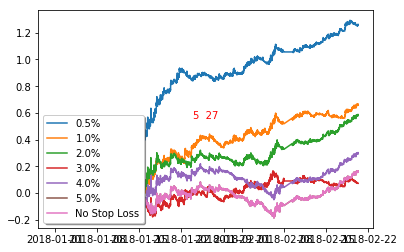

In [29]:
#all_strategy_test([5],[27],[0.005,0.01,0.02,0.03,0.04,0.05],True) # To add more tests for the optimized set
chart_strategy_results([5],[27],stoploss_range,True) # Test

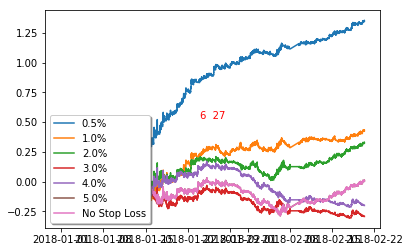

In [30]:
chart_strategy_results([6],[27],stoploss_range,True) # Test

## Finally, we choose (5,27,0.5%) as the optimized set.